<a href="https://colab.research.google.com/github/StevTobs/python_optimization_pyomo/blob/main/IEEE33Bus_LoadFlow_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Flow Analysis on IEEE 33 Bus test system

In [ ]:
# !pip install pypsa
!pip install -U -q PyDrive
# !pip install -q pyomo

In [ ]:
import numpy as np
import pandas as pd
import pypsa


from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 



## Load data

In [ ]:
#Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth) 


# https://drive.google.com/file/d/1G6ssH-4Au0u0H1BbqAQq77GkE1meoXKi/view?usp=sharing
your_module = drive.CreateFile({'id':'1G6ssH-4Au0u0H1BbqAQq77GkE1meoXKi'}) 
your_module.GetContentFile('33BusTest-line.csv')
line_data = pd.read_csv("33BusTest-line.csv", names=['No','FormBus','ToBus','R','X'] ).dropna(axis=1)
line_data.set_index('No',inplace=True)


# https://drive.google.com/file/d/1AbmF9wFDhrXykr38XJ9iUD20cNPVfKRE/view?usp=sharing
your_module = drive.CreateFile({'id':'1AbmF9wFDhrXykr38XJ9iUD20cNPVfKRE'}) 
your_module.GetContentFile('33BusTest-load.csv')
load_data = pd.read_csv("33BusTest-load.csv").dropna(axis=1)
load_data.columns =['BusID','P_KW','Q_KVAr']

# load_data.set_index('BusID',inplace=True)


In [ ]:
#Converse to Per-Unit


MVA_base = 100.0; # Defining the Base-MVA
KV_base = 12.66;
Z_base = KV_base * KV_base / MVA_base;

line_data.R = line_data.R / Z_base
line_data.X = line_data.X / Z_base

load_data.P_KW = load_data.P_KW/MVA_base/1000
load_data.Q_KVAr = load_data.Q_KVAr/MVA_base/1000


In [ ]:
line_data.head()

,FormBus,ToBus,R,X
No,,,,
1,1,2,0.057526,0.029324
2,2,3,0.307595,0.156668
3,3,4,0.228357,0.116300
4,4,5,0.237778,0.121104
5,5,6,0.510995,0.441115


In [ ]:
load_data.head()

,BusID,P_KW,Q_KVAr
0,2.0,0.0010,0.0006
1,3.0,0.0009,0.0004
2,4.0,0.0012,0.0008
3,5.0,0.0006,0.0003
4,6.0,0.0006,0.0002


## Load Flow Preparing Data

In [ ]:
network = pypsa.Network()
#Add buses

nbus = 33
for i in range(1,nbus+1):
    network.add("Bus","Bus No {}".format(i),
               v_nom = 1.0)
    
    #Add loads
    
for i in range(len(load_data.BusID)):
    network.add("Load", "Load No {}".format(int(load_data.BusID.iloc[i])),
           bus = "Bus No {}".format(int(load_data.BusID.iloc[i])),
           p_set = load_data.P_KW.iloc[i],
           q_set = load_data.Q_KVAr.iloc[i])
    
print(network.buses.head())
print('-----------------------------------------------')
#Add lines
for i in range(len(line_data.ToBus.loc[:])):
    network.add("Line","Line {}".format(str(line_data.FormBus.iloc[i])+str('-')+ str(line_data.ToBus.iloc[i])),              
                bus0 = "Bus No {}".format(line_data.FormBus.iloc[i]),
                bus1 = "Bus No {}".format(line_data.ToBus.iloc[i]),
                r = line_data.R.iloc[i],
                x = line_data.X.iloc[i])

print(network.lines.head())
print('-----------------------------------------------')
#slack generator
network.add("Generator","Slack Gen",
           bus = "Bus No 1",
           p_set = 0,
           control = 'Slack')

attribute  v_nom type    x    y  ... v_mag_pu_min  v_mag_pu_max  control  sub_network
Bus No 1     1.0       0.0  0.0  ...          0.0           inf       PQ             
Bus No 2     1.0       0.0  0.0  ...          0.0           inf       PQ             
Bus No 3     1.0       0.0  0.0  ...          0.0           inf       PQ             
Bus No 4     1.0       0.0  0.0  ...          0.0           inf       PQ             
Bus No 5     1.0       0.0  0.0  ...          0.0           inf       PQ             

[5 rows x 10 columns]
-----------------------------------------------
attribute      bus0      bus1 type  ...  x_pu_eff  r_pu_eff  s_nom_opt
Line 1-2   Bus No 1  Bus No 2       ...       0.0       0.0        0.0
Line 2-3   Bus No 2  Bus No 3       ...       0.0       0.0        0.0
Line 3-4   Bus No 3  Bus No 4       ...       0.0       0.0        0.0
Line 4-5   Bus No 4  Bus No 5       ...       0.0       0.0        0.0
Line 5-6   Bus No 5  Bus No 6       ...       0.0       0.

In [ ]:
network.buses.head()

attribute,v_nom,type,x,y,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus No 1,1.0,,0.0,0.0,AC,1.0,0.0,inf,PQ,
Bus No 2,1.0,,0.0,0.0,AC,1.0,0.0,inf,PQ,
Bus No 3,1.0,,0.0,0.0,AC,1.0,0.0,inf,PQ,
Bus No 4,1.0,,0.0,0.0,AC,1.0,0.0,inf,PQ,
Bus No 5,1.0,,0.0,0.0,AC,1.0,0.0,inf,PQ,


In [ ]:
network.lines.head()

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,length,terrain_factor,num_parallel,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line 1-2,Bus No 1,Bus No 2,,0.029324,0.057526,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Line 2-3,Bus No 2,Bus No 3,,0.156668,0.307595,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Line 3-4,Bus No 3,Bus No 4,,0.116300,0.228357,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Line 4-5,Bus No 4,Bus No 5,,0.121104,0.237778,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Line 5-6,Bus No 5,Bus No 6,,0.441115,0.510995,0.0,0.0,0.0,False,0.0,inf,1.0,0.0,0.0,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,carrier,marginal_cost,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Slack Gen,Bus No 1,Slack,,0.0,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
network.loads

attribute,bus,type,p_set,q_set,sign
Load No 2,Bus No 2,,0.00100,0.00060,-1.0
Load No 3,Bus No 3,,0.00090,0.00040,-1.0
Load No 4,Bus No 4,,0.00120,0.00080,-1.0
Load No 5,Bus No 5,,0.00060,0.00030,-1.0
Load No 6,Bus No 6,,0.00060,0.00020,-1.0
Load No 7,Bus No 7,,0.00200,0.00100,-1.0
Load No 8,Bus No 8,,0.00200,0.00100,-1.0
Load No 9,Bus No 9,,0.00060,0.00020,-1.0
Load No 10,Bus No 10,,0.00060,0.00020,-1.0
Load No 11,Bus No 11,,0.00045,0.00030,-1.0


INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.038877 seconds


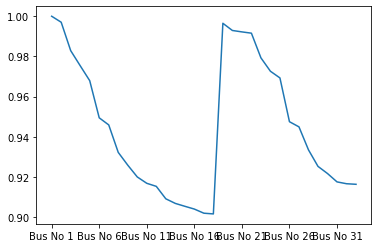

In [ ]:
network.pf()
network.buses_t.v_mag_pu.iloc[0][:].plot()

In [ ]:
network.buses_t.v_mag_pu

,Bus No 1,Bus No 2,Bus No 3,Bus No 4,Bus No 5,Bus No 6,Bus No 7,Bus No 8,Bus No 9,Bus No 10,Bus No 11,Bus No 12,Bus No 13,Bus No 14,Bus No 15,Bus No 16,Bus No 17,Bus No 18,Bus No 19,Bus No 20,Bus No 21,Bus No 22,Bus No 23,Bus No 24,Bus No 25,Bus No 26,Bus No 27,Bus No 28,Bus No 29,Bus No 30,Bus No 31,Bus No 32,Bus No 33
now,1.0,0.997024,0.982885,0.975371,0.96794,0.949451,0.945924,0.932247,0.925901,0.920031,0.916872,0.915353,0.909161,0.906865,0.905435,0.904049,0.901996,0.901638,0.996496,0.992918,0.992213,0.991576,0.9793,0.972628,0.969303,0.947522,0.944957,0.933515,0.925295,0.921737,0.917575,0.916659,0.916375


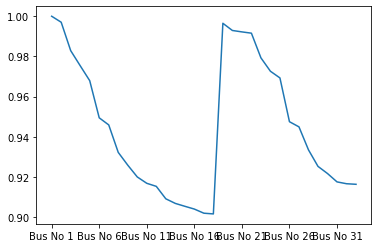

In [ ]:
network.buses_t.v_mag_pu.iloc[0][:].plot()